#### You may wait for several minites to precompile.

In [1]:
using LinearAlgebra, Plots, StatsBase, ProgressMeter
using TensorOperations
versioninfo()

Julia Version 1.4.2
Commit 44fa15b (2020-05-23 18:35 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-6700HQ CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-8.0.1 (ORCJIT, skylake)
Environment:
  JULIA_PKG_SERVER = https://mirrors.bfsu.edu.cn/julia/static


## About MPS
The matrix-product-state type defined by Prof. B Clark at UIUC. See his [Problem Set 3](https://courses.physics.illinois.edu/phys598bkc/fa2015/hw3.html).

In [2]:
# using Iterators

struct Index
    dim::Array{Int64}
    name::Array{String}
end

mutable struct Tensor
    data::Array{Float64}
    index::Index
end

struct MPS
    site::Array{Tensor}
    siteIndex::Array{Integer}
    MPS(A,range) = new(A,collect(range))
end

function makeTensor(theIndex)
#    Tensor(Array(Float64,tuple(theIndex.index_dims[:]...)),theIndex)
    Tensor(zeros(Float64,tuple(theIndex.dim[:]...)),theIndex)
end

global D=6
global spin_deg=2
global mps_size=6

# A complex way to construct the tensor network, do not care the details.
mps=MPS(
        vcat(
            vcat(
                   [makeTensor(Index([1,D,spin_deg],["ileft","i1","s1"]))],
                   [makeTensor(Index([D,D,spin_deg],["i$(i-1)","i$(i)","s$i"])) for i in 2:mps_size-1]
            ),
            [makeTensor(Index([D,1,spin_deg],["i$(mps_size-1)","iright","s$(mps_size)"]))]
        ),
        1:mps_size
)

println("MPS generated")

MPS generated


In [3]:
println("MPS length = ", length(mps.site))
println("MPS left-site dims =    ", size(mps.site[1].data))
println("MPS middle-site dims =  ", size(mps.site[2].data))
println("MPS right-site dims =   ", size(mps.site[end].data))

MPS length = 6
MPS left-site dims =    (1, 6, 2)
MPS middle-site dims =  (6, 6, 2)
MPS right-site dims =   (6, 1, 2)


## Starting SVRG program first trial

#### Define functions 

In [4]:
function generate_MPS(func::Function; D=6, spin_deg=2, mps_size=8)::MPS
    
    makeTensor(theIndex) = Tensor( func(Float64,tuple(theIndex.dim[:]...) ),theIndex)
    mps = MPS(
        vcat(
            vcat(
                   [makeTensor(Index([1,D,spin_deg],["ileft","i1","s1"]))],
                   [makeTensor(Index([D,D,spin_deg],["i$(i-1)","i$(i)","s$i"])) for i in 2:mps_size-1]
            ),
            [makeTensor(Index([D,1,spin_deg],["i$(mps_size-1)","iright","s$(mps_size)"]))]
        ),
        1:mps_size
    )
    return mps
end

function generate_Heisenberg_Hamiltonian()
    σx = [0  1;1  0]
    iσy = [0 1;-1  0]
    σz = [1  0;0  -1]
    self_kron(A::Matrix) = tensorproduct(A,(11,19),A,(21,29),(11,21,19,29))
    H = 0.25*(self_kron(σx)-self_kron(iσy)+self_kron(σz))
    return H # J=1
end

function generate_Heisenberg_Hamiltonian(Jx,Jy,Jz)
    σx = [0  1;1  0]
    iσy = [0 1;-1  0]
    σz = [1  0;0  -1]
    self_kron(A::Matrix) = tensorproduct(A,(11,19),A,(21,29),(11,21,19,29))
    # bug??
    H = 0.25*(Jx*self_kron(σx)-Jy*self_kron(iσy)+Jz*self_kron(σz))
    return H
end

function generate_eye()
    eye = [1 0;0 1]
    self_kron(A::Matrix) = tensorproduct(A,(11,19),A,(21,29),(11,21,19,29))
    eye2 = 1.0*self_kron(eye)
    return eye2
end

function sparse_indices(H)::Dict
    C1 = CartesianIndices(H[:,:,1,1])
    C2 = CartesianIndices(H[1,1,:,:])
    D = Dict{Tuple{Int8,Int8},Array{Tuple{Int8,Int8,Float64},1}}()
    for i in C1
        tmp = Tuple{Int8,Int8,Float64}[]
        # adding diagonal index(j=i) first
        push!(tmp,(i.I...,H[i,i]))
        for j in C2
            if i != j && H[i,j] != 0.0
                push!(tmp,(j.I...,H[i,j]))
            end
        end
        push!(D, i.I => tmp)
    end
    return D
end

sparse_indices (generic function with 1 method)

In [5]:
# right regularization:
# BBB  B
# BBB RA
# BBB' A
# BBRA A
# BB' AA
function right_regularize!(mps::MPS)
    arrS = mps.site
    len = length(arrS)
    for i in len:-1:2
        A = arrS[i].data
        B = arrS[i-1].data
        l, r, s = arrS[i].index.dim
        F = lq( reshape(A,l,r*s) )
        if l <= r*s
            A[:] = reshape(Matrix(F.Q),l,r,s)
            # the "l r s" below are just simbols in the macro, they are not what we defined above.
            @tensor C[l,r',s] := B[l,r,s]*F.L[r,r']
        else
            A[:] = reshape(Matrix(I,l,r*s)*F.Q,l,r,s)
            L = 0.0*Matrix(I,l,l)
            L[:,1:r*s] = F.L
            @tensor C[l,r',s] := B[l,r,s]*L[r,r']
        end
        B[:] = C
    end
    arrS[1].data[:] = arrS[1].data / norm(arrS[1].data,2)
#     normalize!(arrS[1].data)
end

function exact_energy!(mps::MPS)::Real
    right_regularize!(mps)
    S = mps.site
    Et = 0.0
    A = S[1].data
    B = S[2].data
    # all real numbers in A, B, H.
    @tensoropt Ei[:] := A[l,Lu,s11]*B[Lu,r,s21]*H[s11,s21,s12,s22]*A[l,Ld,s12]*B[Ld,r,s22]
    Et += scalar(Ei)
    for i in 2:length(S)-1
        P = S[i-1].data
        A = S[i].data
        B = S[i+1].data
        l, r, s = S[i-1].index.dim
        M = tensorcopy(P,(1,2,3),(1,3,2))
        F = qr( reshape(M,l*s,r) )
        if l*s < r
            P2 = reshape( F.Q*Matrix(I,l*s,r), l,s,r )
            R = 0.0*Matrix(I,r,r)
            R[1:l*s,:] = F.R
            @tensor C[l',r,s] := R[l',l]*A[l,r,s]
        else
            P2 = reshape( Matrix(F.Q),l,s,r )
            R = F.R
            @tensor C[l',r,s] := R[l',l]*A[l,r,s]
        end
        tensorcopy!(P2,(1,3,2),P,(1,2,3))
        A[:] = C
        @tensoropt Ei[:] := A[l,Lu,s11]*B[Lu,r,s21]*H[s11,s21,s12,s22]*A[l,Ld,s12]*B[Ld,r,s22]
        Et += scalar(Ei)
    end
    return Et
end

function exact_energy(mps1::MPS)::Real
    mps = deepcopy(mps1)
    right_regularize!(mps)
    S = mps.site
    Et = 0.0
    A = S[1].data
    B = S[2].data
    # all real numbers in A, B, H.
    @tensoropt Ei[:] := A[l,Lu,s11]*B[Lu,r,s21]*H[s11,s21,s12,s22]*A[l,Ld,s12]*B[Ld,r,s22]
    Et += scalar(Ei)
    for i in 2:length(S)-1
        P = S[i-1].data
        A = S[i].data
        B = S[i+1].data
        l, r, s = S[i-1].index.dim
        M = tensorcopy(P,(1,2,3),(1,3,2))
        F = qr( reshape(M,l*s,r) )
        if l*s < r
            P2 = reshape( F.Q*Matrix(I,l*s,r), l,s,r )
            R = 0.0*Matrix(I,r,r)
            R[1:l*s,:] = F.R
            @tensor C[l',r,s] := R[l',l]*A[l,r,s]
        else
            P2 = reshape( Matrix(F.Q),l,s,r )
            R = F.R
            @tensor C[l',r,s] := R[l',l]*A[l,r,s]
        end
        tensorcopy!(P2,(1,3,2),P,(1,2,3))
        A[:] = C
        @tensoropt Ei[:] := A[l,Lu,s11]*B[Lu,r,s21]*H[s11,s21,s12,s22]*A[l,Ld,s12]*B[Ld,r,s22]
        Et += scalar(Ei)
    end
    return Et
end

function exact_Sz(mps1::MPS)::Real
    mps = deepcopy(mps1)
    right_regularize!(mps)
    S = mps.site
    len = length(S)
    Szt = 0.0
    A = S[1].data
#     B = S[2].data
    Ŝz = Matrix(0.5*Diagonal( (spin_deg-1):-2:-(spin_deg-1) ) )
    # all real numbers in A, B, H.
    @tensoropt Sz[:] := A[l,r,s1]*Ŝz[s1,s2]*A[l,r,s2]
    Szt += scalar(Sz)
    for i in 2:len
        P = S[i-1].data
        A = S[i].data
#         B = S[i+1].data
        l, r, s = S[i-1].index.dim
        M = tensorcopy(P,(1,2,3),(1,3,2))
        F = qr( reshape(M,l*s,r) )
        if l*s < r
            P2 = reshape( F.Q*Matrix(I,l*s,r), l,s,r )
            R = 0.0*Matrix(I,r,r)
            R[1:l*s,:] = F.R
            @tensor C[l',r,s] := R[l',l]*A[l,r,s]
        else
            P2 = reshape( Matrix(F.Q),l,s,r )
            R = F.R
            @tensor C[l',r,s] := R[l',l]*A[l,r,s]
        end
        tensorcopy!(P2,(1,3,2),P,(1,2,3))
        A[:] = C
        @tensoropt Sz[:] := A[l,r,s1]*Ŝz[s1,s2]*A[l,r,s2]
        Szt += scalar(Sz)
    end
    return Szt/len
end

function print_mat(A::AbstractArray)
    show(stdout,"text/plain",A)
    println(stdout,"")
end

print_mat (generic function with 1 method)

In [6]:
mps = generate_MPS(rand; D=D, spin_deg=spin_deg, mps_size=mps_size)
H = generate_Heisenberg_Hamiltonian()
spH = sparse_indices(H)
print_mat(mps.site[1].data)

right_regularize!(mps)

print_mat(mps.site[1].data)
exact_energy!(mps)

1×6×2 Array{Float64,3}:
[:, :, 1] =
 0.543294  0.472094  0.66534  0.662924  0.893427  0.571089

[:, :, 2] =
 0.824276  0.310466  0.539582  0.501181  0.457332  0.328254
1×6×2 Array{Float64,3}:
[:, :, 1] =
 -0.784959  -0.130359  0.00878559  -0.000136319  0.00167333  0.000672634

[:, :, 2] =
 -0.6002  -0.0806192  0.00484651  -0.00118978  0.000879742  0.000386621


1.20317004342669

In [7]:
mutable struct Sample
    state::Vector{Int8}
    inner::Float64   #W(S)
    energy::Float64  #E(S)
end

mutable struct Node
    spin::Int8
    value::Float64
    parent::Int32
end

function generate_BTree(s::Int)::Vector{Node}
    l = 2^(s+1)-2
    W = Vector{Node}(undef,l)
    for i in 1:2:l-1
        W[i] = Node(1,0.0,(i-1)/2)
    end
    for i in 2:2:l
        W[i] = Node(2,0.0,i/2-1)
    end
    return W
end
    

function next(tmp::Vector{Int8})
    l = length(tmp)
    new = deepcopy(tmp)
    for i in 1:2:l-1
        if tmp[i] != tmp[i+1]
            new[i] = tmp[i+1]
            new[i+1] = tmp[i]
        end
    end
    selected = StatsBase.sample(1:l,Int(ceil(l/4)),replace=false,ordered=true)
    new[selected] = 3 .- new[selected]
    return new
end

function state_inner(tmp::Sample,mps::MPS)
    l = length(tmp.state)
    if length(mps.site) != l
        throw(DomainError( (l,length(mps.site)), "length dismatch" ))
    end
    matchain = Array{Matrix{Float64},1}(undef,l)
    for i in 1:l
        spin = tmp.state[i]
        matchain[i] = mps.site[i].data[:,:,spin]
    end
    inner = matchain[1]
    for i in 2:l
        inner = inner*matchain[i]
    end
    return inner[1,1]
end

function state_inner(state::Vector{Int8},mps::MPS)
    l = length(state)
    if length(mps.site) != l
        throw(DomainError( (l,length(mps.site)), "length dismatch" ))
    end
    matchain = Array{Matrix{Float64},1}(undef,l)
    for i in 1:l
        spin = state[i]
        matchain[i] = mps.site[i].data[:,:,spin]
    end
    inner = matchain[1]
    for i in 2:l
        inner = inner*matchain[i]
    end
    return inner[1,1]
end

function calc_Es(sample::Sample, mps::MPS, spH::Dict)::Float64
    state = sample.state
    S = mps.site
    l = length(S)
    Es_diag = 0.0
    Es_offdiag = 0.0
    W = sample.inner
    for i in 1:l-1
        spin = (state[i], state[i+1])
        for (s1,s2,e) in spH[spin]
            if (s1, s2) == spin
                Es_diag += e
            else
                dual_state = deepcopy(state)
                dual_state[i:i+1] = [s1,s2]
                W′ = state_inner(dual_state,mps)
                Es_offdiag += W′*e
            end
        end
    end
    return Es_diag + Es_offdiag/W
end

calc_Es (generic function with 1 method)

In [8]:
# not a gradient actually, it just contracts MPS's matrix except the given one(with index n).
function single_site_grad(state, mps::MPS, H, n)
    S = mps.site
    l = length(state)
    if length(S) != l
        throw(DomainError( (l,length(mps.site)), "length dismatch" ))
    end
    matchain = Array{Matrix{Float64},1}(undef,l)
    for i in 1:l
        spin = state[i]
        matchain[i] = S[i].data[:,:,spin]
    end
    lmat = 1.0
    rmat = 1.0
    for i in 1:n-1
        lmat = lmat*matchain[i]
    end
    for i in n+1:l
        rmat = rmat*matchain[i]
    end
    G = zeros(Float64,size(S[n].data))
    G[:,:,state[n]] = (rmat*lmat)'
    return G
end

function tr2vec(Tree::Vector{Node},node_number)
    i = node_number
    j = mps_size
    chain = Vector{Int8}(undef, mps_size)
    while j != 0 
        chain[end+1-j] = Tree[i].spin
        i = Tree[i].parent
        j -= 1
    end
    return chain
end

# from 2^k-1 to 2(2^k-1) are samples' <S'|H|S >. S: temporary(tmp) state.
function generate_samples!(Tree,tmp,H,mps)
    K = mps_size
    for k in 2:K
        for i in 2^k-1:2*(2^k-1)
            j = Tree[i].parent
            s11 = Tree[j].spin
            s12 = Tree[i].spin
            s21 = tmp.state[k-1]
            s22 = tmp.state[k]
            Tree[i].value = Tree[j].value +   H[s11,s12,s21,s22]
        end
    end
    samples = Vector{Sample}(undef,2^K)
    D = view(Tree,2^K-1:2*(2^K-1))
    for k in 1:2^K
        state = tr2vec(Tree,k+2^K-2)
        samples[k] = Sample(state,state_inner(state,mps),D[k].value)
        
    end
    return samples
end

function gradSampleGenerate(mps::MPS, H, chainlen)
    S = mps.site
    Ns = length(S)
    chain = rand(Int8.(1:spin_deg),Ns)
    tmp = Sample(chain,1e-5,0.0)
    new = tmp
    samples = Vector{Sample}(undef,chainlen)
    
    for i in 1:Int(ceil(chainlen/2.5))
        new = Sample(next(tmp.state), 0.0, 0.0)
        new.inner = state_inner(new, mps)
        if rand() < (new.inner/tmp.inner)^2
            tmp = new
        end
        # heating, do nothing here
    end
    
    samples = Vector{Sample}(undef,chainlen)
    Es_sum = 0.0   # ∑ E(S)
    grad = Vector{Array{Float64,3}}(undef,mps_size)
    for i in 1:mps_size
        # will be used to store ∑2/W(S)|S>
        grad[i] = zero(S[i].data)
    end
    delta = zero.(grad)
    
    tmp.energy = calc_Es(tmp, mps, spH)
    for i in 1:chainlen
        new = Sample(next(tmp.state), 0.0, 0.0)
        new.inner = state_inner(new, mps)
        if rand() < (new.inner/tmp.inner)^2
            tmp = new
            tmp.energy = calc_Es(tmp, mps, spH)
        end
        
        # tmp.energy: E(S)
        Es_sum += tmp.energy
        samples[i] = tmp
        for i in 1:mps_size
            B = 2/tmp.inner*single_site_grad(tmp.state, mps, H, i)
            delta[i] += B
            grad[i] += B*tmp.energy
        end
    end
    grad ./= chainlen
    delta ./= chainlen
    Es_sum /= chainlen
    grad = grad .- Es_sum.*delta
    return grad, Es_sum, samples
end

function exact_grad(mps::MPS, H)
    S = mps.site
    K = length(S)
    D = view(Tree,2^K-1:2*(2^K-1))
    # list all possible states in samples[], we only use samples[i].state
    samples = Vector{Sample}(undef,2^K)
    for k in 1:2^K
        state = tr2vec(Tree,k+2^K-2)
        samples[k] = Sample(state,0.0,0.0)
    end
    for tmp in samples
        # W(S)
        tmp.inner = state_inner(tmp, mps)
        # E(S)
        tmp.energy = calc_Es(tmp, mps, spH)
    end
    grad = gradFromSet(mps, H, samples)
    return grad
end

function gradFromSet(mps::MPS, mps_old::MPS, H, set)
    S_new = mps.site
    S_old = mps_old.site
    Es_sum = 0.0   # ∑ E(S)
    psum = 0.0 # Σ ρ'/ρ
    grad = Vector{Array{Float64,3}}(undef,mps_size)
    for i in 1:mps_size
        # ∑ 2/W(S)|S>
        grad[i] = zero(S_new[i].data)
    end
    delta = zero.(grad)
    for sp in set
        rate = (state_inner(sp,mps)/sp.inner)^2
        psum += rate
        
#         Estate = generate_samples!(Tree,sp,H,mps)
#         println(Estate) #test
#         energy = sum(x->x.energy * x.inner / sp.inner, Estate)
#         energy1 = sum(y -> y.energy * y.inner / sp.inner, Estate)
#         println(energy1)
        energy1 = calc_Es(sp, mps, spH)
        Es_sum += energy1*rate
        
        for i in 1:mps_size
            B = 2/sp.inner*single_site_grad(sp.state, mps, H, i)
            delta[i] += B*rate
            grad[i] += B*sp.energy*rate
        end
    end
    grad ./= psum
    delta ./= psum
    Es_sum /= psum
    grad = grad .- Es_sum.*delta
    return grad
end

function gradFromSet(mps::MPS, H, set)
    S = mps.site
    Es_sum = 0.0   # ∑ E(S)
    grad = Vector{Array{Float64,3}}(undef,mps_size)
    for i in 1:mps_size
        # ∑ 2/W(S)|S>
        grad[i] = zero(S[i].data)
    end
    delta = zero.(grad)
    for sp in set
        Es_sum += sp.energy
        
        for i in 1:mps_size
            B = 2/sp.inner*single_site_grad(sp.state, mps, H, i)
            delta[i] += B
            grad[i] += B*sp.energy
        end
    end
    chainlen = length(set)
    grad ./= chainlen
    delta ./= chainlen
    Es_sum /= chainlen
    grad = grad .- Es_sum.*delta
    return grad
end

function mkReweightSGD(mps1::MPS, H; step=20,chainlen=200,η=0.005)
    mps = deepcopy(mps1)
    val = Vector{Float64}(undef,step+1)
    val[1] = exact_energy!(mps)
    progress1 = Progress(step)
    energy1 = 0.0
    for j in 1:step
        grad, energy1, _ = gradSampleGenerate(mps, H, chainlen)
        g = grad
        for i in 1:mps_size
#             mps.site[i].data[:] = mps.site[i].data - η*g[i]
            mps.site[i].data[:] = mps.site[i].data - η*(1/(i/200+1))*g[i]
        end
#         val[j+1] = exact_energy(mps)
        val[j+1] = energy1
        next!(progress1)
    end
    return val, mps
end

function mkAdam(mps1::MPS, H; step=20,chainlen=200,η=0.005, β1=0.9, β2=0.999, ϵ=1e-8)
    mps = deepcopy(mps1)
    val = Vector{Float64}(undef,step+1)
    val[1] = exact_energy!(mps)
    progress1 = Progress(step)
    energy1 = 0.0
    grad, _, _ = gradSampleGenerate(mps, H, 2)
    g = zero.(grad)
    v = zero.(g)
    for j in 1:step
        grad, energy1, _ = gradSampleGenerate(mps, H, chainlen)
        for i in 1:mps_size
            g[i] = β1*g[i]+(1-β1)*grad[i]
            v[i] = β2*v[i]+(1-β2)*grad[i].^2
            ηt = η*sqrt(1-β2^j)/(1-β1^j)
#             mps.site[i].data[:] = mps.site[i].data - η*g[i]
            mps.site[i].data[:] = mps.site[i].data - ηt*(g[i]./(sqrt.(v[i]).+ϵ*sqrt(1-β2^j)))
        end
#         val[j+1] = exact_energy(mps)
        val[j+1] = energy1
        next!(progress1)
    end
    return val, mps
end

function mkReweightSVRG(mps1::MPS, H; outer=20,inner=10,long=200,short=40,η=0.005)
    mps = deepcopy(mps1)
    val = Vector{Float64}(undef,inner*outer+1)
    val[1] = exact_energy!(mps)
    progress1 = Progress(outer)
    energy1 = 0.0
    for i in 1:outer
        mps_old = deepcopy(mps)
        grad, energy1, set = gradSampleGenerate(mps, H, long)
        for j in 1:inner
            
#             _, subset = gradSampleGenerate(mps,H,short)
            partlink = StatsBase.sample(1:long,short,replace=false,ordered=true)
            subset = set[partlink]
            
            g = grad-gradFromSet(mps_old,H,subset)+gradFromSet(mps_old,mps,H,subset)
#             g = g - ψ'*g*ψ
#             mps.site = mps.site .- η.*g
            for i in 1:mps_size
                mps.site[i].data[:] = mps.site[i].data - η*g[i]
            end
            val[(i-1)*inner+j+1] = exact_energy(mps)
#             val[(i-1)*inner+j+1] = energy1
        end
        next!(progress1)
    end
    return val, mps
end

function tgReweightSVRG(mps1::MPS, H; outer=2,inner=10,long=200,short=40,η=0.005)
    mps = deepcopy(mps1)
    val = Vector{Float64}(undef,inner*outer+1)
    val[1] = exact_energy!(mps)
    progress1 = Progress(outer)
    energy1 = 0.0
    for i in 1:outer
        mps_old = deepcopy(mps)
        _, energy1, set = gradSampleGenerate(mps, H, long)
        grad = exact_grad(mps, H)
        for j in 1:inner
#             _, subset = gradSampleGenerate(mps,H,short)
            partlink = StatsBase.sample(1:long,short,replace=false,ordered=true)
            subset = set[partlink]
            g = grad-gradFromSet(mps_old,H,subset)+gradFromSet(mps_old,mps,H,subset)
#             g = g - ψ'*g*ψ
#             mps.site = mps.site .- η.*g
            for i in 1:mps_size
                mps.site[i].data[:] = mps.site[i].data - η*g[i]
            end
            val[(i-1)*inner+j+1] = exact_energy(mps)
#             val[(i-1)*inner+j+1] = energy1
        end
        next!(progress1)
    end
    return val, mps
end

tgReweightSVRG (generic function with 1 method)

In [15]:
global D=8
global spin_deg=2
global mps_size=12
global Tree = generate_BTree(mps_size)
# H = generate_Heisenberg_Hamiltonian(-1,-1,-1)
# E0 = -0.25*(mps_size-1)
H = generate_Heisenberg_Hamiltonian(1,1,1)
E0 = -0.75*(mps_size)+sin(2π/mps_size)/(1-cos(2π/mps_size))

spH = sparse_indices(H)
mps = generate_MPS(rand; D=D, spin_deg=spin_deg, mps_size=mps_size)
print_mat(mps.site[1].data)

right_regularize!(mps)

println("\n\n")
print_mat(mps.site[1].data)
exact_energy!(mps)
println("\n E0 = ",E0)

1×8×2 Array{Float64,3}:
[:, :, 1] =
 0.2867  0.450461  0.516413  0.290318  0.688896  0.557727  0.109495  0.116945

[:, :, 2] =
 0.740226  0.762906  0.26897  0.368899  0.994105  0.590084  0.333505  0.795535



1×8×2 Array{Float64,3}:
[:, :, 1] =
 -0.528884  0.016895  0.00535793  0.0092372  -0.00186704  -0.000266078  0.000105983  -4.3525e-5

[:, :, 2] =
 -0.848339  0.00736432  -0.00353791  0.0112888  -0.00207062  -0.00016566  0.000461409  -0.000296086

 E0 = -5.2679491924311215


#### SVRG with stochastic total-batch gradient

In [ ]:
# data1g, mps2 = mkReweightSVRG(mps, H, outer=150,inner=10,long=1500,short=75,η=0.03)
data1g, mps2 = mkReweightSVRG(mps, H, outer=150,inner=10,long=1000,short=75,η=0.03)
# strf = string(" Szf = ", round(exact_Sz(mps2),sigdigits=3) )
dt = log10.(data1g.-E0)
fig1 = plot(dt,title="SVRG_rand, step=0.03", lw=1.5,size=[700,400],
            xlabel="steps",ylabel="Log(E)", label="L=$mps_size, D=$D")

In [ ]:
# fig12 = plot(data1g,title="SVRG_rand, step=0.03", lw=1.5,size=[700,400],
#             xlabel="steps",ylabel="Log(E)", label="L=$mps_size, D=$D")
fig12 = fig1
savefig(fig12, "./texfile/svrg_rand3.pdf")
fig12

In [ ]:
savefig(fig1, "svrg_rand.pdf")

#### SVRG with exact total-batch gradient

In [ ]:
data1, mps2 = tgReweightSVRG(mps, H, outer=15,inner=10,long=1500,short=75,η=0.006)
strf = string(" Szf = ", round(exact_Sz(mps2),sigdigits=3) )
fig2 = plot(log10.(data1.-E0), title="SVRG_exact, step=0.015", lw=1.5,size=[700,400],
            xlabel="steps",ylabel="Log(E)", label="L=$mps_size, D=$D")

In [ ]:
fig22 = plot(data1, title="SVRG_exact, step=0.015", lw=1.5,size=[700,400],
            xlabel="steps",ylabel="Log(E)", label="L=$mps_size, D=$D")
savefig(fig22,"svrg_exact2.pdf")
fig22

In [ ]:
savefig(fig2,"svrg_exact.pdf")
fig2

#### SGD

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


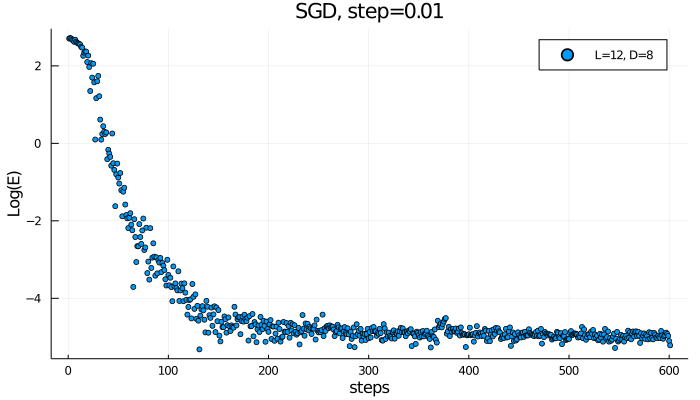

In [17]:
step = 0.01
data2, mps1 = mkReweightSGD(mps, H; step=600,chainlen=400,η=step)
# # str1 = string(" average Szt = ", round(exact_Sz(mps1),sigdigits=3) )
# fig3 = scatter(log10.(abs.((data2.-E0))), title="SGD, step=$step",ms=3,coclr=:skyblue, size=[700,400],
#             xlabel="steps",ylabel="Log(E)", label="L=$mps_size, D=$D")
fig3 = scatter(data2, title="SGD, step=$step",ms=3,coclr=:skyblue, size=[700,400],
            xlabel="steps",ylabel="Log(E)", label="L=$mps_size, D=$D")

In [ ]:
# fig32 = plot(data2, title="SGD, step=0.06", lw=1.5,size=[700,400],
#             xlabel="steps",ylabel="energy", label="L=$mps_size, D=$D")
fig32 = fig3
savefig(fig32,"./texfile/sgd5.pdf")
fig32

#### Adam

Progress: 100%|█████████████████████████████████████████| Time: 0:02:02


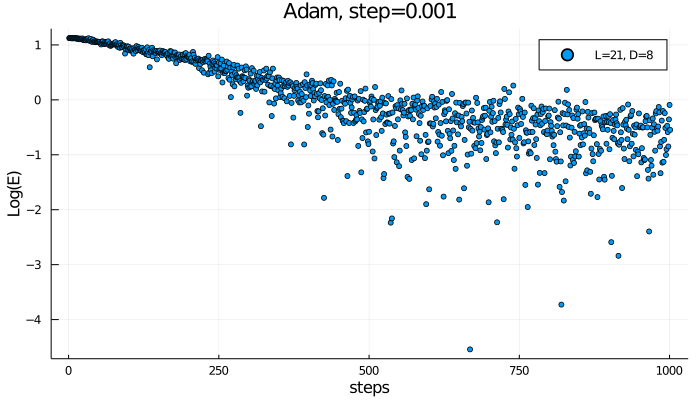

In [74]:
η = 0.001
data1a, mps2 = mkAdam(mps, H; step=1000,chainlen=200,η=η)
dt = log10.(abs.(data1a.-E0))
figa = scatter(dt,title="Adam, step=$(η)", ms=3, size=[700,400],
            xlabel="steps",ylabel="Log(E)", label="L=$mps_size, D=$D")

In [ ]:
savefig(figa, "./texfile/AdamScatter.pdf")
figa

#### Test

Here are some tests. ↓

In [ ]:
global D=1
global spin_deg=2
global mps_size=2

mps = generate_MPS(rand; D=D, spin_deg=spin_deg, mps_size=mps_size)
show(stdout,"text/plain",mps.site[1].data)

right_regularize!(mps)

println("\n\n")
show(stdout,"text/plain",mps.site[1].data)
exact_energy!(mps)